In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = ["#00A6D6", "white", "#EC6842"]
tu_delft_diverging = LinearSegmentedColormap.from_list("tu_delft_diverging", colors)
mpl.colormaps.register(cmap=tu_delft_diverging)
plt.style.use("../styles/tu_delft.mplstyle")

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
from myst_nb import glue

# Monte Carlo simulation

## What approximating integrals has to do with stochastic modeling

Many applications of stochastic modeling in engineering require evaluating integrals of probability density functions. For example, in a temperature forecast, you might want the expected value or variance of the predicted temperature; in flood modeling, you may need the exceedance probability for a certain water level. All of these quantities are defined by integrals. Even obtaining marginal distributions from a joint distribution of two variables involves integration.

If the variables of interest follow simple, well-characterized distributions (e.g., Gaussian), these integrals can often be computed analytically. Real-world models, however, are usually more complex: the variables may not follow simple distributions, the model outputs may be highly non-linear, and the models are often multi-dimensional. In such cases, analytical solutions are not feasible, and we must evaluate the integrals numerically.

In one dimension, conventional numerical integration techniques like quadrature rules can work. For instance, we could evaluate the function on a regular grid and integrate using the trapezoidal rule. However, in higher dimensions, these approaches become quickly inefficient.

An alternative is to approximate the integral using random samples — this is called *Monte Carlo integration*. It is intuitive because it mirrors how we are used to think about probability distributions: to approximate the expected value of a variable, we calculate the mean of a set of samples. A Monte Carlo estimate works in the same way: generate random samples from the probability density function, then compute their average.

The next section examines how to approximate integrals with Monte Carlo estimators in more detail. The rest of this chapter focuses on the first step: generating samples from the probability density function of interest.



## Monte Carlo estimator

Monte Carlo methods are particularly suitable for evaluating expected values of random variables.
That is, we can approximate integrals of the following form:

$$F = \int_{-\infty}^{\infty} f(x) p(x) dx$$

where $p(x)$ is the probability density function (PDF) associated with a random variable $X$, and $f(x)$ is a function.
Note that most of the integrals we are interested in (e.g., variance, expectation, cumulative probabilities) can be written in this form when we choose an appropriate function $f$.

`````{admonition} Example
:class: tip, dropdown

The following examples show how we can write the variance and cumulative probability in the form of an expectation.

The variance is defined as the expected value of the squared deviation from the mean of a random variable. For a continuous random variable $X$ with PDF $p(x)$ and expected value $\mu$, this means:

$$\mathrm{Var}(X) = \int_{-\infty}^{\infty} (x-\mu)^2 p(x) dx$$

This is an integral of the required form for $f(x) = (x-\mu)^2$.

The cumulative probability $P(X\leq x^\ast)$ is given by:

$$
\begin{aligned}
P(X\leq x^\ast) &= \int_{-\infty}^{x^\ast} p(x) dx\\
&= \int_{-\infty}^{\infty} h(x) p(x) dx
\end{aligned}
$$

where

$$
h(x) = 
\begin{cases}
1, \quad \text{if }x\leq x^\ast\\
0, \quad \text{otherwise}
\end{cases}
$$

is an indicator function.
Again, if $f(x) = h(x)$, the cumulative probability can be expressed in the required integral form.

`````

The Monte Carlo estimator $\hat{F}$ of the integral $F$ is:

$$\hat{F} = \frac{1}{N} \sum_{i}^N f(X_i)$$

where $X_i$ are independent random variables distributed according to $p(x)$.
In practice, we generate realizations $x_i$ from this distribution and evaluate the estimator using these sample values.
That is, we evaluate the function $f$ for each of the random samples and average the result.

### Unbiasedness

A nice property of the Monte Carlo estimator is that it is unbiased, i.e., the expectation of the Monte Carlo estimator equals the true integral:

$$\mathbb{E}[\hat{F}] = F$$

`````{admonition} Proof
:class: tip, dropdown

$$
\begin{aligned}
\mathbb{E}[\hat{F}] &= \mathbb{E}\left[\frac{1}{N} \sum_{i=1}^{N} f(X_i)\right]\\
&= \frac{1}{N} \sum_{i=1}^{N} \mathbb{E}[f(X_i)]\\
&= \mathbb{E}[f(X)]\\
&= \int_{-\infty}^{\infty} f(x) p(x) dx\\
&= F
\end{aligned}
$$

`````

### Error and convergence

Even though the Monte Carlo estimator is unbiased, it always has an error because we can only generate a finite number of samples.
The variance of the Monte Carlo estimator is:

$$\operatorname{Var}[\hat{F}] = \frac{1}{N} \operatorname{Var}[f(X)]$$

The corresponding standard error (i.e., the standard deviation of the estimator) is:

$$\operatorname{SE}[\hat{F}] = \frac{1}{\sqrt{N}} \sqrt{\operatorname{Var}[f(X)]}$$

That is, the standard error decreases with the square root of the number of samples.
For example, improving the accuracy of the estimator by a factor of 10 requires 100 times more samples, meaning that convergence is relatively slow.
Notice that the standard error formula does not depend on the dimension of $X$. This is why Monte Carlo integration avoids the exponential increase in computational cost that conventional quadrature methods suffer from in high-dimensional problems.

Of course, to apply Monte Carlo integration we first need to be able to generate samples from the distributions of interest — the next sections show how this can be done in practice.

## Generating samples

### Transformations of a random variable

Often, we do not sample directly from the distribution of interest, but from another, simpler one.
If the variable we want to simulate can be expressed as a transformation of another random variable, we can use the transformation method.
This is often the case in modeling, where a model maps uncertain inputs to uncertain outputs.

Let $X$ be a random variable with known distribution $p_X(x)$ – you could think about it as an input parameter to a model for an engineering application.

$$Y = g(X)$$

is a new random variable obtained by applying a deterministic transformation $g$, representing our model, to $X$.

Now we are interested in the distribution of $Y$, $p_Y(y)$.
For simple cases, it can be derived analytically using the *change of variables* formula, which requires that $g$ is monotonic and invertible.
However, in Monte Carlo simulation we typically do not need to derive $p_Y$ explicitly, since sampling through the transformation is enough.

If we already have samples $x_i$ drawn from $X$, then obtaining samples of $Y$ is straightforward:

$$y_i = g(x_i)$$

That is, we simply apply the transformation $g$ (our model) to each sample.
Each transformed value  $y_i=g(x_i)$ is one realization of the random variable $Y=g(X)$.

This simple principle — generating new random variables by transforming samples — underlies many more advanced sampling methods, including inverse transform sampling, which we will explore next.

#### Example

Suppose $X∼N(0,1)$, and define $Y=X^2$.
We can easily generate samples of $Y$ by squaring the samples of $X$:

In [4]:
samples = stats.norm(0, 1).rvs(10000)
transformed = samples**2

The resulting distribution of $Y$ follows a chi-square distribution with one degree of freedom (see {numref}`fig-transform-samples`), but we never needed to compute that analytically to obtain valid samples.

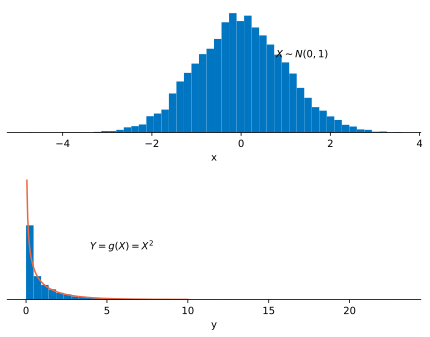

In [5]:
y_dense = np.linspace(0, 10, 200)
pdf_chi_square = stats.chi2(df=1).pdf(y_dense)

fig, axs = plt.subplots(2, 1)
axs[0].hist(samples, bins=50,density=True)
axs[0].text(s=r"$X \sim N(0, 1)$", x=0.65, y=0.6, transform=axs[0].transAxes)
axs[0].set_xlabel("x")
axs[1].hist(transformed, bins=50, density=True)
axs[1].text(s="$Y = g(X) = X^{2}$", x=0.2, y=0.4, transform=axs[1].transAxes)
axs[1].plot(y_dense, pdf_chi_square, label="Chi-square PDF", color="C1")
axs[1].set_xlabel("y")
plt.tight_layout()
sns.despine(fig, left=True)
for a in axs.flat:
    a.set_yticks([])
glue("transform_samples_fig", plt.gcf(), display=False)

```{glue:figure} transform_samples_fig
:width: 80%
:name: "fig-transform-samples"

Transforming Monte Carlo samples. The upper plot shows a histogram of samples from $X$. Squaring samples of $X$ gives the samples shown in the lower histogram. For comparison, the PDF of a chi-square distribution with one degree of freedom is shown in orange.
```


### Inverse transform sampling

We can use this trick of transforming samples to generate samples from a large class of parametric distributions if we consider a special type of transformation: the inverse cumulative distribution function (inverse CDF). Hereby, we can leverage the fact that applying the cumulative distribution function of a random variable to its own samples produces values that are uniformly distributed on $(0, 1)$.

Consider that you want to generate samples of a random variable $X$ with probability density function $f(x)$.
Further assume that the cumulative distribution function $F(x)$ has a closed form solution and is invertible.
Last but not least, you are also able to generate samples from a uniform distribution.

In that case, we can generate samples from $X$ as follows:

1. Derive an expression for the inverse CDF (also called *quantile function*), $F^{-1}(u)$.
2. Draw random samples $u_i$ from a uniform distribution on the interval $(0, 1)$.
3. Generate samples $x_i$ as $x_i = F^{-1}(u_i)$

This works because, for any continuous random variable $X$, the transformation $U=F(X)$ produces a uniform random variable on $(0, 1)$, and conversely, 
$X=F^{−1}(U)$ produces samples distributed as $X$.

This method is simple and useful but also limited: it requires the CDF to be invertible, which generally restricts it to one-dimensional distributions. For multivariate cases, inverse transform sampling can only be applied if the variables are independent, allowing sampling from each marginal separately.

#### Example

Consider the Gumbel distribution (see {numref}`fig-inverse-sampling`). It's CDF is:

$$u = F(x) = \mathrm{e}^{-\mathrm{e}^{-\frac{x-\mu}{\beta}}}$$

We can solve this expression for $x$ to obtain the inverse distribution function:

$$x = F^{-1}(u) = \mu - \beta \ln(-\ln(u))$$

Now we draw samples from a uniform distribution:


In [6]:
import numpy as np
import scipy.stats as stats

u = stats.uniform.rvs(size=5)
print(f"u = {u}")


u = [0.96153003 0.27164858 0.75059759 0.75973624 0.82089546]


Then we plug in the values $u_i$ into the inverse distribution function (here using $\mu=0$ and $\beta=1$):

In [7]:
x = -np.log(-np.log(u))
print(f"x = {x}")

x = [ 3.23832684 -0.26485809  1.24867174  1.29177008  1.62272829]


The generated samples are from the Gumbel distribution.

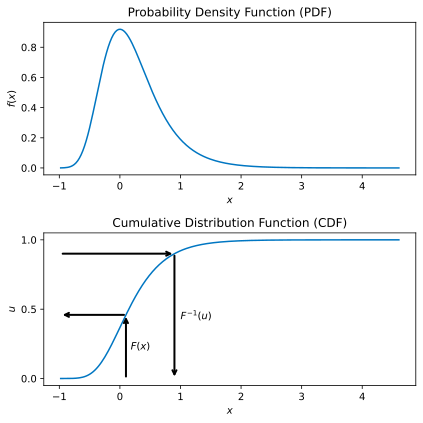

In [8]:
dist = stats.gumbel_r(scale=0.4)

alpha = 1e-5
x = np.linspace(dist.ppf(alpha), dist.ppf(1-alpha), num=200)
u = dist.cdf(x)
p = dist.pdf(x)

# Set up the subplot figure for PDF and CDF side by side
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Left subplot: PDF
ax[0].plot(x, p)
ax[0].set_xlabel("$x$")
ax[0].set_ylabel(r"$f(x)$")
ax[0].set_title("Probability Density Function (PDF)")

# Right subplot: CDF with transformation arrows
ax[1].plot(x, u)
ax[1].set_xlabel("$x$")
ax[1].set_ylabel(r"$u$")
ax[1].set_title("Cumulative Distribution Function (CDF)")

# Annotate transformation from x to F(x)
x_value = 0.1  # Example x-value for arrow
u_value = dist.cdf(x_value)

ax[1].annotate(
    "",
    xy=(x_value, u_value),
    xytext=(x_value, 0),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].annotate(
    "",
    xytext=(x_value, u_value),
    xy=(x[0], u_value),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].text(x_value + 0.4, u_value / 2, "$F(x)$", ha="right", va="center", color="black")
plt.yticks([0, 0.5, 1])

# Annotate transformation from u to F(u)
u_value = 0.9  # Example x-value for arrow
x_value = dist.ppf(u_value)

ax[1].annotate(
    "",
    xytext=(x_value, u_value),
    xy=(x_value, 0),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].annotate(
    "",
    xy=(x_value, u_value),
    xytext=(x[0], u_value),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].text(
    x_value + 0.1, u_value / 2, "$F^{-1}(u)$", ha="left", va="center", color="black"
)
plt.yticks([0, 0.5, 1])

fig.tight_layout()

glue("inverse_sampling_fig", fig, display=False)

```{glue:figure} inverse_sampling_fig
:width: 80%
:name: "fig-inverse-sampling"

Inverse transform sampling illustrated with the Gumbel distribution. The CDF (lower panel) maps values from $x$ to probabilities in the interval $(0, 1)$.
We can invert this process by generating samples from a uniform distribution and applying the inverse CDF $F^{-1}(u)$.
```

#### Interactive Animation

<iframe src="../_static/elements/element_sampling_inverse_cdf.html" width="100%" height="500" frameborder="0"></iframe>


### Rejection sampling

The methods for generating samples that we covered so far are limited to some special cases where we have a considerable amount of pre-knowledge about the distribution we want to sample.
For many other applications, however, we need more general methods with less requirements.

A simple but more general method is rejection sampling. 
The general idea of rejection sampling is to first generate samples from a known distribution (the so-called *proposal distribution*) and then discard samples that are inconsistent with the distribution we are interested in (the *target distribution*).
This "correction" is done by comparing the PDF of the proposal distribution, $q(x)$, to the target PDF $p(x)$.

```{glue:figure} rejection_sampling_fig_1
:width: 150%
:name: "fig-rejection-sampling-1"
:figclass: margin

Proposal and target distribution.
```


In [9]:
# Define the target distribution
def evaluate_target_pdf(x):
    """Target distribution with two peaks."""
    return 0.3 * np.exp(-0.2 * (x - 2) ** 2) + 0.7 * np.exp(-0.2 * (x + 2) ** 2)


def evaluate_proposal_pdf(x):
    return proposal.pdf(x)


def get_proposal_samples(N):
    return proposal.rvs(N)

In [10]:
from sampling import rejection_sampling

N = 1000
proposal = stats.norm(loc=0, scale=3)
proposal_samples, proposal_pdf, u, accept, M = rejection_sampling(
    N, evaluate_target_pdf, evaluate_proposal_pdf, get_proposal_samples
)

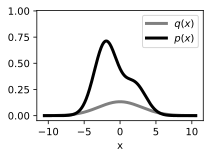

In [11]:
fig, axs = plt.subplots(1, figsize=(3, 2))
x_lim = np.max(np.abs(proposal_samples))
x = np.linspace(-x_lim, x_lim, 500)
plt.plot(x, evaluate_proposal_pdf(x) * M, lw=3, color="grey", alpha=0)
plt.plot(x, evaluate_proposal_pdf(x), label="$q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_1", fig, display=False)

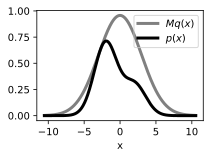

In [12]:
fig, axs = plt.subplots(1, figsize=(3, 2))
x_lim = np.max(np.abs(proposal_samples))
x = np.linspace(-x_lim, x_lim, 500)
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_2", fig, display=False)

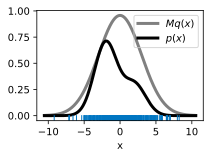

In [13]:
fig, axs = plt.subplots(1, figsize=(3, 2))
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
sns.rugplot(proposal_samples[::3], expand_margins=False, height=0.05)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_3", fig, display=False)


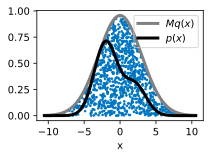

In [14]:
fig, axs = plt.subplots(1, figsize=(3, 2))
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.scatter(
    proposal_samples,
    M * proposal_pdf * u,
    color="C0",
    s=3,
)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_4", plt.gcf(), display=False)

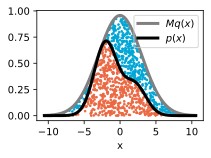

In [15]:
fig, axs = plt.subplots(1, figsize=(3, 2))
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.scatter(
    proposal_samples,
    M * proposal_pdf * u,
    c=accept,
    s=3,
    cmap="tu_delft_diverging"
)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_5", plt.gcf(), display=False)


#### Algorithm

1. Define a proposal distribution with density $q(x)$ ({numref}`fig-rejection-sampling-1`).
   
   In principle, we can freely choose this density, but there are two important requirements: It should be defined over the same range of $x$ values as $p(x)$, and we need to be able to generate samples from this distribution.
   Later on, you will also see that it is beneficial if $q(x)$ resembles $p(x)$ as much as possible.

```{glue:figure} rejection_sampling_fig_2
:width: 150%
:name: "fig-rejection-sampling-2"
:figclass: margin

Scaling the proposal distribution.
```

2. Scale the proposal density such that is always greater than or equal to the target density ({numref}`fig-rejection-sampling-2`).

   That is, we define a scaling constant $M$ so that

   $$\quad Mq(x) \geq p(x) \quad \forall x$$

   In practice, determining the scaling constant $M$ is a bit tricky because we do not know the target PDF globally. We can only evaluate it at individual points.
   Therefore, in practice, this condition is loosened, only requiring that it is fulfilled for all samples $x_i$ that we generate in the next step.

```{glue:figure} rejection_sampling_fig_3
:width: 150%
:name: "fig-rejection-sampling-3"
:figclass: margin

Sampling the proposal distribution.
```

3. Generate samples from the proposal distribution.

   That is, we obtain samples $x_i$ from $X \sim q(x)$. In ({numref}`fig-rejection-sampling-3`), these samples are indicated as small blue bars on the $x$-axis.

```{glue:figure} rejection_sampling_fig_4
:width: 150%
:name: "fig-rejection-sampling-4"
:figclass: margin

Sampling a uniform distribution.
```

4. Draw random values $u_i$ uniformly between $0$ and $Mq(x_i)$.

   For each sample $x_i$, we draw one sample $u_i$ from a uniform distribution $U_i \sim \text{Uniform}(0, M q(x_i))$.
   In ({numref}`fig-rejection-sampling-4`), each $u_i$ is plotted against the corresponding $x_i$.
   In this way, we generate dots that cover the area below the proposal distribution.

```{glue:figure} rejection_sampling_fig_5
:width: 150%
:name: "fig-rejection-sampling-5"
:figclass: margin

Rejecting samples.
```

5. Accept $x_i$ if $u_i \leq p(x_i)$. Otherwise, reject.

   Intuitively, this means that points falling under the curve of the target density are kept (colored orange in {numref}`fig-rejection-sampling-5`), while those above it are discarded (rejected).


#### Limitations

Rejection sampling is simple and conceptually elegant, but it can become very inefficient if the proposal distribution $q(x)$ differs greatly from the target $p(x)$.
Visually, this means that most sampled points fall in regions where $Mq(x)$ greatly exceeds $p(x)$, so most samples are rejected.

Efficiency also drops sharply in higher dimensions. In one dimension, it corresponds to the ratio of the area under $p(x)$ to that under $Mq(x)$; in higher dimensions, the ratio involves volumes, which shrink rapidly as the number of dimensions increases. This phenomenon is known as the *curse of dimensionality*.

### Importance sampling

Importance sampling follows a similar idea as rejection sampling: we draw samples from an easier proposal distribution $q(x)$ instead of the target distribution $p(x)$.
Rather than rejecting samples based on the ratio $\frac{p(x)}{q(x)}$, we use this ratio as a weight in the estimator.
All samples are kept, but their influence is adjusted according to how well they represent the target distribution.
This approach is often more efficient when $q(x)$ resembles $p(x)$ in the regions that contribute most to the integral.
We will return to importance sampling later in the course, in the context of data assimilation.

The next chapter introduces Markov chain Monte Carlo (MCMC) methods, which build on the same idea of using a simpler distribution to explore a more complex one — but instead of assigning weights, they generate a chain of dependent samples that collectively follow the target distribution.